## Week 13: Banderias formulation and fully exploit sparsity.

Previous week we demonstrated how to reformulate a communicability resolvent problem in order to exploit spartisty(to some extend). That formulation was based in the balanced min-cut problem. The main aim for this week is to: analayze Banderias formulation which includes the balancing term in the objective function, and to fully exploit sparsity by means of an additional change of variables. As secondary objectives, I will try to find more motivational examples on clustering based on communicability, implement the problem with CVXOPT and find a good binary graph dataset with ground truth. 

     1. Banderias formulation
         1.1 Show equivalence
         1.2 Exploring impact of delta in balanced cut
         1.3 Exploring impact of gamma in bandeira cut
     2. Fully exploit sparsity
         2.1 Second change of variables


In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import expm
from scipy.sparse.linalg import eigs
from scipy.special import factorial
from scipy.sparse import csr_matrix
from sklearn.cluster import k_means 
from sys import path
import cvxpy as cvx
from cvxopt import matrix
#custom libraries
path.insert(0, "../")
import tools_graphs as tg
import utils
import solvers as sv
import seaborn as sns; sns.set(color_codes=True) 

def get_labels(X, assign_labels='sampling'):
    #x.T*x solution. Need to sample one x.
    Vr,wr = sv.evd(matrix(X),scaled=True)
    if assign_labels == 'truncated':
        return np.array([0 if vi >= 0.0 else 1 for vi in list(Vr[:,0])])
    elif assign_labels == 'sampling':
        return sv.sampler(csr_matrix(A),Vr)
    elif assign_labels == 'kmeans':
        inl, labels,c = k_means(np.array(Vr),2)
        return labels

def balanced_cut(A, delta = 1):
    m,n = A.shape
    X = cvx.Semidef(m)
    obj = cvx.Maximize(cvx.trace(X*A))
    constr_eq = [X[i,i]==1 for i in range(m)]
    constr_ineq = [cvx.trace(np.ones((m,n))*X) <= delta**2]
    prob = cvx.Problem(obj,constr_eq+constr_ineq)
    prob.solve(solver=cvx.MOSEK)
    return np.array(X.value)
    
def bandeira_cut(A, gamma=0.5, assign_labels='sampling'):
    N = A.shape[0]
    B = A-gamma*np.ones(A.shape)
    X = cvx.Semidef(N)
    obj = cvx.Maximize(cvx.trace(B*X))
    constr_eq = [X[i,i]==1 for i in range(N)]
    prob = cvx.Problem(obj,constr_eq) 
    prob.solve()
    return np.array(X.value)
  

### 1. Banderias-cut vs Balanced-cut

In [ ]:
N = 40; ratio = 0.3
A, labels, G, node_color = tg.sample_SBM(N,0.4,0.1,ratio)
nx.draw(G,node_color=node_color); plt.title('Generated graph');plt.show()
delta = int(N-(2*N*ratio))

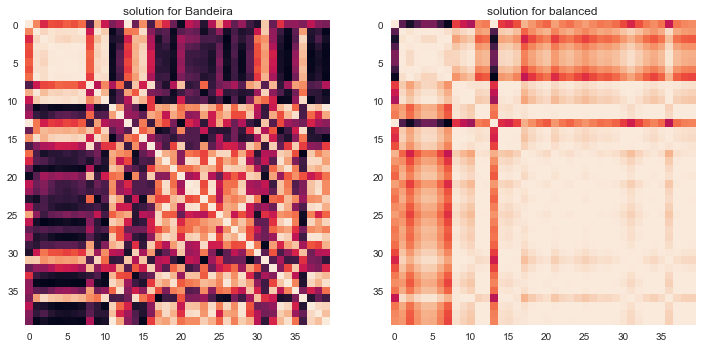

In [70]:
#Banderias formulation of the problem
Xban = bandeira_cut(A,0.3)
xban = get_labels(Xban, assign_labels='sampling')
Xbal = balanced_cut(A,delta)
xbal = get_labels(Xbal, assign_labels='truncated')
fig, axarr = plt.subplots(1,2)
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.grid"] = False
axarr[0].imshow(Xban); axarr[0].set_title('solution for Bandeira')
axarr[1].imshow(Xbal); axarr[1].set_title('solution for balanced');plt.show()

In [29]:
print("Solution balanced cut:\n {}").format(xbal)
print("Solution bandeira cut:\n {}").format(xban)
print("Real cut solution lab:\n {}").format(np.array(labels))

Solution balanced cut:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
Solution bandeira cut:
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1]
Real cut solution lab:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


At first sight both methods lead to the same solution. Both for the solution of the semidefinite programming problem and after sampling from X. However is difficult to assest what is the impact of both tunning parameters $\delta$ and $\gamma$. We know that both parameters play a role on balancing the cuts as for example $\delta = 0 $ try to force two balanced clusters since $\ones^T x=\delta=0$ for equal number of -1 and +1. However the sampling process from the low rank matrix breaks the balancing contraint as we only keep the solutions that best fit the objective.

#### Studying the effect of delta for balanced cut

In [35]:
"""Analyzing the solver balanced_cut for different values of the balancing parameter delta.
For each delta, 10 different fully connected graphs are generated
The measurments are closseness to rank 1 of the semidefinte solution, and for each labeler method 
the accuracy, balancing ratio and violation of balancing constraint"""
N = 40
true_ratio = 0.333
true_deltad = int(N-(2*N*ratio))
delta_list = np.logspace(0,np.log10(N-3),30)#from completly balance to completly disbalance

In [8]:
n_delts = len(delta_list)
n_inits = 10
results = {'ratio':np.zeros((n_inits,n_delts,3)),'accuracy':np.zeros((n_inits,n_delts,3)),
           'violation':np.zeros((n_inits,n_delts,3)),'rank':np.zeros((n_inits,n_delts))}
print "starting.."
for j,delta in enumerate(delta_list):
    #print("going with delta {}...").format(delta)
    for i in range(n_inits): #running algorithm on 10 different graphs
        A, labels, G, node_color = tg.sample_SBM(N,0.5,0.2,true_ratio)
        X = balanced_cut(A,delta)
        results['rank'][i,j] = abs(np.linalg.eig(X)[0][0]-N)
        for p,method in enumerate(['sampling','truncated','kmeans']):
            x = get_labels(X, assign_labels=method)
            results['accuracy'][i,j,p] = utils.get_error(labels,x)
            results['ratio'][i,j,p] = utils.get_ratio(x)
            x[x==0]=-1
            results['violation'][i,j,p] = abs(np.dot(x,np.dot(np.ones((N,N)),x))-delta**2)
print("Finished without errors.. from delta={} to delta={}").format(delta_list[0],delta_list[-1])

starting..
Finished without errors.. from delta=1.0 to delta=37.0


[Text(0,0.5,u'ratio balance'), Text(0.5,0,u'delta')]

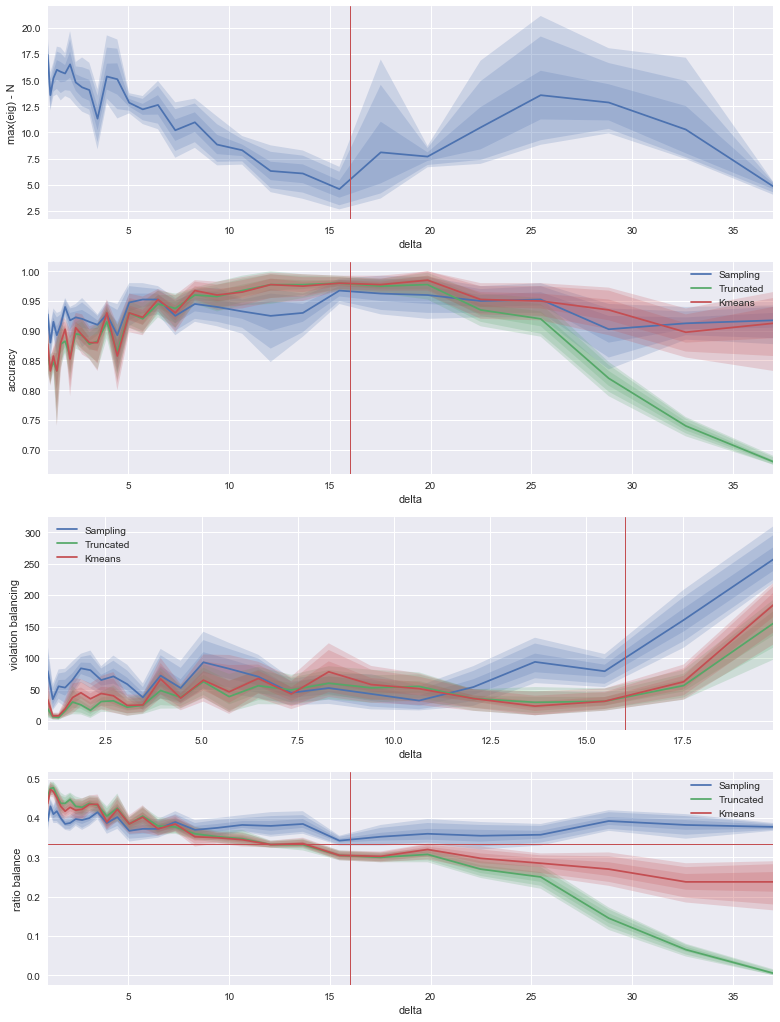

In [48]:
import pickle
with open('../../datasets/dict_deltas.pickle', 'rb') as handle:
    results = pickle.load(handle) 
methods = ['Sampling','Truncated','Kmeans']
#!/usr/bin/env python -W ignore::DeprecationWarning
plt.rcParams["axes.grid"] = True
fig, ax = plt.subplots(4,1)
plt.rcParams["figure.figsize"] = (13,18)
sns.tsplot(data=results['rank'],time=delta_list,ci=[68, 95, 99],ax=ax[0])
sns.tsplot(data=results['accuracy'],time=delta_list,ci=[68, 95, 99],ax=ax[1],condition=methods)
sns.tsplot(data=results['violation'][:,:25,:],time=delta_list[:25],ci=[68, 95, 99],ax=ax[2],condition=methods)
sns.tsplot(data=results['ratio'],time=delta_list,ci=[68, 95, 99],ax=ax[3],condition=methods)
ax[0].axvline(x=true_deltad, linewidth=1, color='r')
ax[0].set(xlabel='delta', ylabel='max(eig) - N')
ax[1].axvline(x=true_deltad, linewidth=1, color='r')
ax[1].set(xlabel='delta', ylabel='accuracy')
ax[2].axvline(x=true_deltad, linewidth=1, color='r')
ax[2].set(xlabel='delta', ylabel='violation balancing')
ax[3].axvline(x=true_deltad, linewidth=1, color='r')
ax[3].axhline(true_ratio, linewidth=1, color='r')
ax[3].set(xlabel='delta', ylabel='ratio balance')


### Studying the effect of gamma in bandeira-cut

In [51]:
"""Same than for balanced cut but with Bandeira_cut to stydu the effect of gamma
This time we cant measure how much the disbalance constraint is violated since we
dont have it(explicitily)."""
N = 40
true_ratio = 0.333
gamma_list = np.linspace(0.01,1.1,30) #from completly balance to completly disbalance

In [4]:
n_gamms = len(gamma_list)
n_inits = 10
results_gamma = {'ratio':np.zeros((n_inits,n_gamms,3)),'accuracy':np.zeros((n_inits,n_gamms,3)),
                 'rank':np.zeros((n_inits,n_gamms))}
print "starting.."
for j,gamma in enumerate(gamma_list):
    #print("going with gamma {}...").format(gamma)
    for i in range(n_inits): #running algorithm on 10 different graphs
        A, labels, G, node_color = tg.sample_SBM(N,0.5,0.2,true_ratio)
        X = bandeira_cut(A,gamma)
        results_gamma['rank'][i,j] = abs(np.linalg.eig(X)[0][0]-N)
        for p,method in enumerate(['sampling','truncated','kmeans']):
            x = get_labels(X, assign_labels=method)
            results_gamma['accuracy'][i,j,p] = utils.get_error(labels,x)
            results_gamma['ratio'][i,j,p] = utils.get_ratio(x)
print("Finished without errors.. from gamma={} to gamma={}").format(gamma_list[0],gamma_list[-1])

starting..
Finished without errors.. from gamma=0.01 to gamma=1.1


[Text(0,0.5,u'ratio balance'), Text(0.5,0,u'delta')]

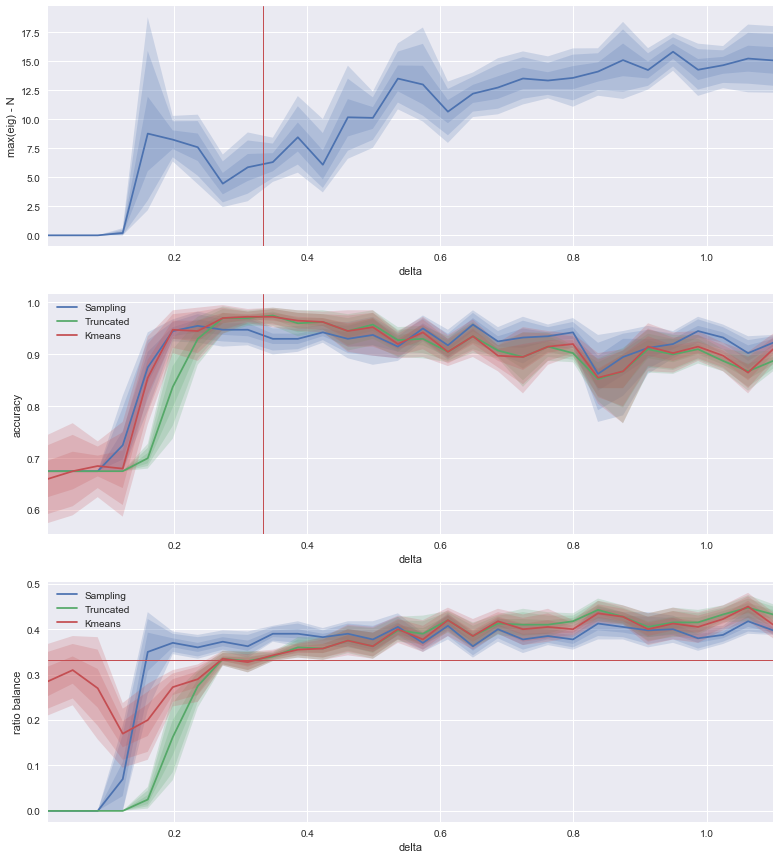

In [52]:
with open('../../datasets/dict_gammas.pickle', 'rb') as handle:
    results_gamma = pickle.load(handle)
#!/usr/bin/env python -W ignore::DeprecationWarning
plt.rcParams["axes.grid"] = True
fig, ax = plt.subplots(3,1)
plt.rcParams["figure.figsize"] = (13,15)
sns.tsplot(data=results_gamma['rank'],time=gamma_list,ci=[68, 95, 99],ax=ax[0])
sns.tsplot(data=results_gamma['accuracy'],time=gamma_list,ci=[68, 95, 99],ax=ax[1],condition=methods)
sns.tsplot(data=results_gamma['ratio'],time=gamma_list,ci=[68, 95, 99],ax=ax[2],condition=methods)
ax[0].axvline(x=true_ratio, linewidth=1, color='r')
ax[1].axvline(x=true_ratio, linewidth=1, color='r')
ax[2].axhline(true_ratio, linewidth=1, color='r')
ax[0].set(xlabel='delta', ylabel='max(eig) - N')
ax[1].set(xlabel='delta', ylabel='accuracy')
ax[2].set(xlabel='delta', ylabel='ratio balance')

## 2. Exploiting sparsity

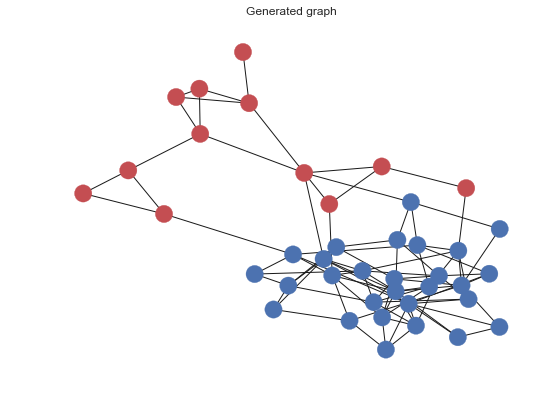

In [9]:
N = 40; ratio = 0.3
A, labels, G, node_color = tg.sample_SBM(N,0.15,0.02,ratio)
plt.rcParams["figure.figsize"] = (7,5)
nx.draw(G,node_color=node_color); plt.title('Generated graph');plt.show()

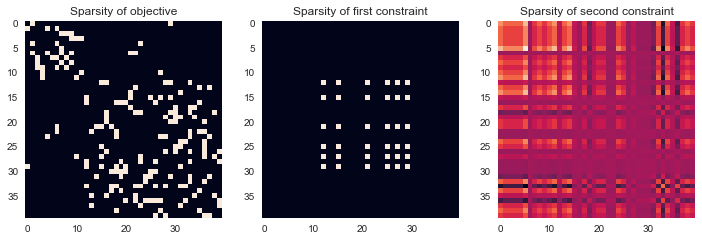

In [25]:
def Ei(i,N):
    Ei = np.zeros((N,N))
    Ei[i,i] = 1
    return Ei

alpha = (1/float(N-1))
alpha = (0.95/np.max(np.linalg.eig(A)[0]))
Rp = (np.eye(N)-alpha*A)
C1 = np.dot(np.dot(Rp.T,Ei(15,N)),Rp) #Rp.T*Ei(i,N)*Rp
C2 = np.dot(np.dot(Rp.T,np.ones(Rp.shape)),Rp) #Rp.T*np.ones(Rp.shape)*Rp
fig, axarr = plt.subplots(1,3)
#Show sparsity pattern
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["axes.grid"] = False
axarr[0].imshow(-(Rp-np.eye(N)))
axarr[0].set_title("Sparsity of objective")
C1[C1!=0]=1
axarr[1].imshow(C1)
axarr[1].set_title("Sparsity of first constraint")
axarr[2].imshow(C2)
axarr[2].set_title("Sparsity of second constraint")
plt.show()

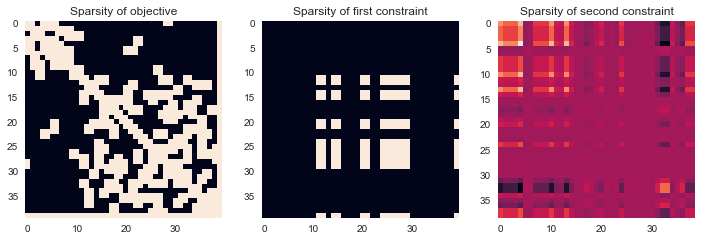

In [29]:
from cvxopt import amd,sparse
v = np.dot(np.ones(N),Rp)
def orthM(v,N):
    offdiag = [-v[i] for i in range(N-1)]
    diag = [v[i+1] for i in range(N-1)]+[v[-1]]
    F =  np.diag(diag)-np.diag(offdiag,-1)
    F[:,-1] = v
    F = (1/np.linalg.norm(v)**2)*F
    return F
F = orthM(v,N)
#p = amd.order(sparse(matrix(Rp)))
#Rp = matrix(Rp)[p,p]
Ao = np.dot(F.T,np.dot(Rp,F))
C2o = np.dot(F.T,np.dot(C2,F))
C1o = np.dot(F.T,np.dot(C1,F))
Ao[Ao!=0]=1
C1o[C1o!=0]=1

#Show sparsity pattern
fig, axarr = plt.subplots(1,3)
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["axes.grid"] = False
axarr[0].imshow(Ao)
axarr[0].set_title("Sparsity of objective")
axarr[1].imshow(C1o)
axarr[1].set_title("Sparsity of first constraint")
axarr[2].imshow(C2o[:N-1,:N-1])
axarr[2].set_title("Sparsity of second constraint")
plt.show()

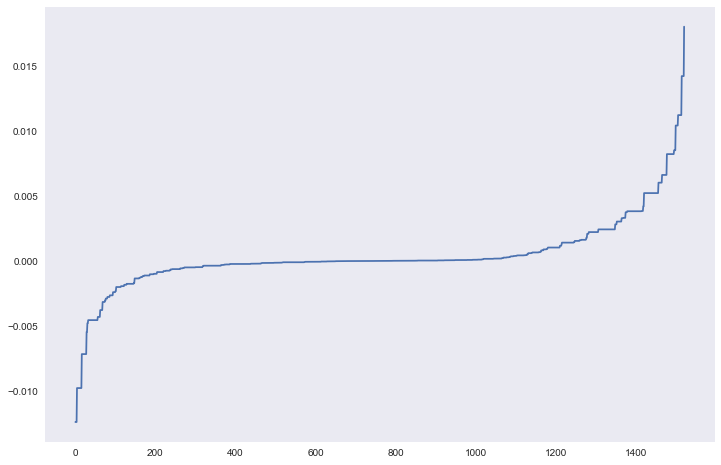

In [30]:
plt.plot(np.sort(C2o[:N-1,:N-1].flatten()))

In [28]:
C2o[C2o==0]

array([], dtype=float64)

### After meeting notes...